# Mask Identity Check – brain/knee × acc × N
해당 노트북은 **readout 길이 N**과 **배속(acc)** 가 동일하면
모든 파일의 k‑space 마스크가 완전히 동일한지 검증합니다.

1. `DATA_DIR` 경로를 자신의 FastMRI 폴더로 수정
2. 셀 전체 실행 → 그룹별 비교 결과 및 불일치 사례 출력


In [1]:
import os, re, glob, h5py, numpy as np, pandas as pd, warnings
from collections import defaultdict
from tqdm.auto import tqdm
warnings.filterwarnings("ignore")

# === 수정하세요 ===
DATA_DIR = "/home/swpants05/Desktop/2025_FastMri/Data"
# DATA_DIR = "/path/to/FastMRI/Data"

REG = re.compile(r"(brain|knee)_acc([48])_(\d+)\.h5")
LB_REG = re.compile(r"(brain|knee)_test(\d+)\.h5")

def list_files(split, dtype):
    if split in ("train","val"):
        return sorted(glob.glob(os.path.join(DATA_DIR, split, dtype, "*.h5")))
    if split=="leaderboard":
        return sorted(glob.glob(os.path.join(DATA_DIR, split, "acc*", dtype, "*.h5")))
    return []

files = {s:list_files(s,"kspace") for s in ("train","val","leaderboard")}
print({k:len(v) for k,v in files.items()})


{'train': 340, 'val': 60, 'leaderboard': 116}


In [2]:
def load_mask(p):
    with h5py.File(p,'r') as f:
        return f['mask'][()].astype(bool)

mask_groups = defaultdict(list)   # key -> list[filepath]
for split,plist in files.items():
    for p in plist:
        fname = os.path.basename(p)
        mm = REG.search(fname)
        if mm:
            body, acc, _ = mm.groups()
        else:
            mm = LB_REG.search(fname)
            if not mm: continue
            body, _ = mm.groups()
            acc = "4" if "/acc4/" in p else "8"
        m = load_mask(p)
        key=(body,int(acc),len(m))
        mask_groups[key].append(p)

print("총 group:", len(mask_groups))


총 group: 19


In [3]:
mismatch = []
for key, paths in tqdm(mask_groups.items(), desc="compare groups"):
    ref = load_mask(paths[0])
    for p in paths[1:]:
        if not np.array_equal(ref, load_mask(p)):
            mismatch.append((key, p))
            break  # 하나만 기록해도 충분

if mismatch:
    print("❌ 불일치 그룹 수:", len(mismatch))
    display(mismatch[:10])
else:
    print("✅ 모든 그룹에서 동일한 마스크가 확인되었습니다!")


compare groups:   0%|          | 0/19 [00:00<?, ?it/s]

✅ 모든 그룹에서 동일한 마스크가 확인되었습니다!


### 시각 확인 (첫 번째 그룹)

예시 그룹: ('brain', 4, 396) 파일 수: 114


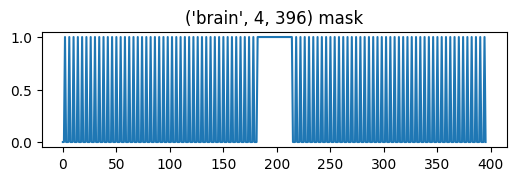

In [4]:
import matplotlib.pyplot as plt
first_key, first_paths = next(iter(mask_groups.items()))
print("예시 그룹:", first_key, "파일 수:", len(first_paths))
m = load_mask(first_paths[0]).astype(int)
plt.figure(figsize=(6,1.5))
plt.title(f"{first_key} mask"); plt.plot(m)
plt.show()
